# Exploitation of simulation algorithm results

In this basic example we are going to retrieve all the results proposed by probability simulation algorithms: the probability estimation, the estimator variance, the confidence interval, the convergence graph of the estimator, the stored input and output numerical samples.

This model is a simple beam, restrained at one side and stressed by a traction load F at the other side.

The geometry is supposed to be deterministic: the diameter D is fixed to D=20 mm.

It is considered that failure occurs when the beam plastifies, i.e. when the axial stress gets bigger than the yield stress:
$$\sigma_e = \frac{F}{\pi-D^2/4} \leq 0$$

Therefore, the state limit G used here is:
$$G = \sigma_e - \frac{F}{\pi-D^2/4}$$

Two independent random variables R and S are considered:

 - R (the strength): $$R = \sigma_e$$
 - S (the load): $$S = \frac{F}{\pi-D^2/4}$$

Stochastic model:

 - F ~ Normal(75e3, 5e3) [N]
 - R ~ LogNormal(300, 30) [N]

Theoretical results:

This two dimensional stochastic problem can be solved by calculating directly the failure probability: 

$$P_f = \text{Prob}(R-S \leq 0) = \int_{r-s \leq 0} f_{R, S}(r, s)drds$$

If R and S are independant, then: 

$$\int_{-\infty}^{+\infty}f_S(x)F_R(x)dx$$

The numerical application gives: $$P_f = 0.0292$$

In [1]:
from __future__ import print_function
import openturns as ot

In [2]:
# create the joint distribution of the parameters
distribution_R = ot.LogNormalMuSigma(300.0, 30.0, 0.0).getDistribution()
distribution_F = ot.Normal(75e3, 5e3)
marginals = [distribution_R, distribution_F]
distribution = ot.ComposedDistribution(marginals)

In [3]:
# create the model
model = ot.SymbolicFunction(['R', 'F'], ['R-F/(_pi*100.0)'])

In [4]:
modelCallNumberBefore = model.getEvaluationCallsNumber()
modelGradientCallNumberBefore = model.getGradientCallsNumber()
modelHessianCallNumberBefore = model.getHessianCallsNumber()

In [5]:
# To have access to the input and output samples
# after the simulation, activate the History mechanism
model.enableHistory()

# Remove all the values stored in the history mechanism
# Care : it is done regardless the status of the History mechanism
model.clearHistory()

In [6]:
# create the event we want to estimate the probability
vect = ot.RandomVector(distribution)
G = ot.RandomVector(model, vect)
event = ot.Event(G, ot.Less(), 0.0)

In [7]:
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.1)
algo.setMaximumStandardDeviation(0.001)
algo.setMaximumOuterSampling(int(1e4))

In [8]:
# Define the HistoryStrategy to store the values of $P_n$ and $\sigma_n$
# used ot draw the convergence graph
# Compact strategy : N points
N = 1000
algo.setConvergenceStrategy(ot.Compact(N))
algo.run()

In [9]:
# retrieve result structure
result = algo.getResult()

In [10]:
# Display the simulation event probability
result.getProbabilityEstimate()

0.030580075662042867

In [11]:
#  Criteria 3 : Display the Standard Deviation of the estimator
result.getStandardDeviation()

0.003057093060511293

In [12]:
# Display the variance of the simulation probability estimator
result.getVarianceEstimate()

9.345817980626304e-06

In [13]:
#  Criteria 2 : Display the Outer Sampling of the simulation
result.getOuterSampling()

3172

In [14]:
# Display the number of iterations executed and the number of
# evaluations of the model
result.getOuterSampling()*result.getBlockSize()

3172

In [15]:
# Save the number of calls to the model, its gradient and hessian done so far
modelCallNumberAfter = model.getEvaluationCallsNumber()
modelGradientCallNumberAfter = model.getGradientCallsNumber()
modelHessianCallNumberAfter = model.getHessianCallsNumber()

# Display the number of iterations executed and
# the number of evaluations of the model
modelCallNumberAfter - modelCallNumberBefore


3172

In [16]:
# Get the mean point in event  domain
# care : only for Monte Carlo and LHS sampling methods
result.getMeanPointInEventDomain()

class=Point name=Unnamed dimension=2 values=[245.843,80222]

In [17]:
# Get the associated importance factors
# care : only for Monte Carlo and LHS sampling methods
result.getImportanceFactors()

class=PointWithDescription name=Unnamed dimension=2 description=[X0,X1] values=[0.776373,0.223627]

In [18]:
# Display the confidence interval length centered around the
# MonteCarlo probability MCProb
# IC = [Probability - 0.5*length, Probability + 0.5*length]
# level 0.95
probability = result.getProbabilityEstimate()
length95 = result.getConfidenceLength(0.95)
print("0.95 Confidence Interval length = ", length95)
print("IC at 0.95 = [", probability - 0.5*length95, "; ", probability + 0.5*length95, "]")

0.95 Confidence Interval length =  0.011983584591978923
IC at 0.95 = [ 0.024588283366053405 ;  0.03657186795803233 ]


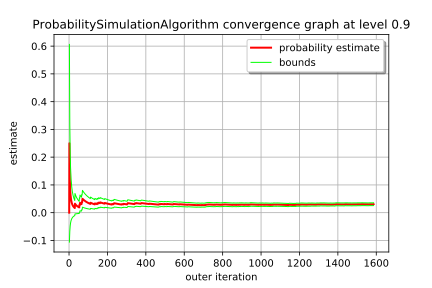

In [19]:
# Draw the convergence graph and the confidence interval of level alpha
# By default, alpha = 0.95
alpha = 0.90
algo.drawProbabilityConvergence(alpha)

In [20]:
# Get the numerical samples of the input and output random vectors
# stored according to the History Strategy specified
# and used to evaluate the probability estimator and its variance
inputSampleStored = model.getHistoryInput().getSample()
outputSampleStored = model.getHistoryOutput().getSample()
inputSampleStored

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=3172 dimension=2 data=[[317.182,68669.1],[285.742,81027.4],[240.137,76750.2],...,[266.956,74830.1],[282.285,78480.2],[247.172,81708.2]]

In [21]:
# Get the values of the estimator and its variance
# stored according to the History Strategy specified
# and used to draw the convergence graph
estimator_probability_sample = algo.getConvergenceStrategy().getSample()[0]
estimator_variance_sample = algo.getConvergenceStrategy().getSample()[1]
print(estimator_probability_sample, estimator_variance_sample)

[0,-1] [0.25,0.046875]
